In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import RNA
from timeit import default_timer as timer
import random
from return_up import return_up
from return_sig_positions import return_sig_positions
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [2]:
datafile = open('./data/ESRseq_scores.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
ESRseq_scores = {}
for row in datareader:
    if row[1] != "":
        ESRseq_scores[row[0]] = float(row[1])
datafile.close()

In [3]:
def predictLEI_archaic(preMRNA,left_flank,right_flank):
    #extract hex sequences from preMRNA
    hexs = [preMRNA[i:i+6] for i in range(left_flank,len(preMRNA)-right_flank-5)]
    #list out significant weighted hex scores
    hexLEIs = []
    for hexSeq in hexs:
        if hexSeq in ESRseq_scores:
            hexLEIs.append(ESRseq_scores[hexSeq])
    #average the hex scores, the following code will break if you input a sequence with only insignificant hexs
    sumScores = sum(hexLEIs)
    return(sumScores)

In [28]:
# valcarcel
datafile = open('./data/valcarcel_data.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
valcarcel_data = {}
for row in datareader:
    #valcarcel_data[row[0]] = [float(row[1]),0]
    #for 2^EI
    valcarcel_data["TGTCCAATGTTCCAACCTACAG" + row[0] + "GTAAGTTCTTGCTTTGTTCAAA"] = [2**float(row[1]),0]
datafile.close()

#hma data
datafile = open('./data/sms_hma_results.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
hma_data = {}
for row in datareader:
    #have to add flanks
    #row[0] is sequence, row[1] is EI, row[2] is rel EI, row[3] is PUP, row[4] is LEI and row[5] is LEIsc
    hma_data[row[0]] = [float(row[4]),0]
datafile.close()

In [16]:
#we will define this function where x is the scale for the weights
def predictLEI(preRNA, left_flank_length, right_flank_length, scale):
    #keep a list of hex scores * scaled availability
    newHexScores = []
    #mfe as follows, then pc
    #folded = RNA.fold(preRNA)[0]
    up_probs = return_up(preRNA)
    
    #print(folded)
    for i in range(left_flank_length,len(preRNA)-right_flank_length-5):
        if preRNA[i:i+6] in ESRseq_scores:
            #the expected value here is dependent on the a single structure (MFE), so it will always be an exact integer
            #expected_val_up = folded[i:i+6].count('.')
            #with the pc
            expected_val_up = sum(up_probs[i:i+6])
            #print("expected_val_up: " + str(expected_val_up))
            #the following factor scales the expected value
            weight = 1 + (scale * ((expected_val_up / 3) - 1))
            newHexScores.append(ESRseq_scores[preRNA[i:i+6]] * weight)
            #print("ESR score: " + str(ESRseq_scores[preRNA[i:i+6]]) + " weight: " + str(weight))
    #average the hex scores, the following code will break if you input a sequence with only insignificant hexs
    sumScores = sum(newHexScores)
    return(sumScores)

r^2 = 0.478
y = 1.226x + -4.882


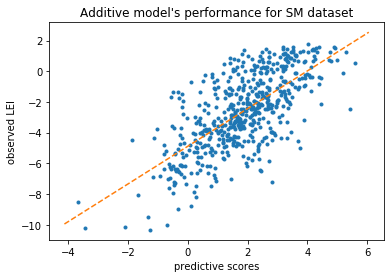

In [9]:
#test this with one scale
for sequence in hma_data:
    hma_data[sequence][1] = predictLEI(sequence,23,16,0)
    # 23 is the length of the left flank and the 16 is the length of the right flank

x_vals = []
y_vals = []

for sequence in hma_data:
    x_vals.append(hma_data[sequence][1]) #x is predicted
    
for sequence in hma_data:
    y_vals.append(hma_data[sequence][0]) #y is observed
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
plt.plot(x_vals,y_vals,'.')
plt.title("Additive model's performance for SM dataset")
plt.xlabel("predictive scores")
plt.ylabel("observed LEI")
abline(slope,intercept)
print("r^2 = " + str(round(r_value**2,3)))
print("y = " + str(round(slope,3)) + "x + " + str(round(intercept,3)))

In [59]:
for sequence in valcarcel_data:
    valcarcel_data[sequence][1] = predictLEI(sequence,22,22,0.5)
    
x_vals = []
y_vals = []

for sequence in valcarcel_data:
    x_vals.append(valcarcel_data[sequence][1]) #x is predicted
    
for sequence in valcarcel_data:
    y_vals.append(valcarcel_data[sequence][0]) #y is observed
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)

r^2 = 0.245
y = 0.167x + 1.985


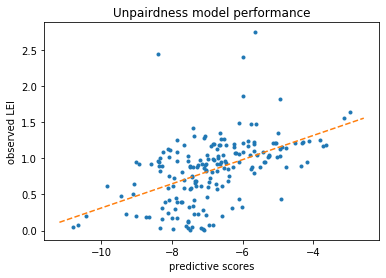

In [60]:
plt.plot(x_vals,y_vals,'.')
plt.title("Unpairdness model performance")
plt.xlabel("predictive scores")
plt.ylabel("observed LEI")
abline(slope,intercept)
print("r^2 = " + str(round(r_value**2,3)))
print("y = " + str(round(slope,3)) + "x + " + str(round(intercept,3)))

In [27]:
def plot_scale_performance(data,left_flank_length, right_flank_length):
    y_vals = []
    x_vals = []
    scale_performance = []
    #following loop will take a few minutes
    for x in range(0,51):
        for sequence in  data:
            data[sequence][1] = predictLEI(sequence,left_flank_length,right_flank_length,x/50)
        for seq in data:
            y_vals.append(data[seq][0]) # y is observed
            x_vals.append(data[seq][1]) # x is predicted
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
        scale_performance.append([x/50, r_value**2])
        x_vals = []
        y_vals = []
    return(scale_performance)

r^2 = 0.9744194349351913
y = -0.13221794226322048x + 0.3042195320290598


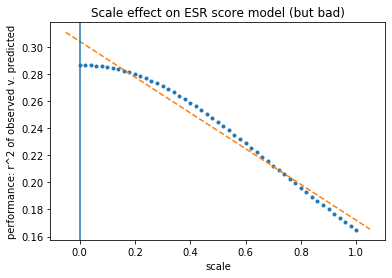

In [33]:
scale_performance = plot_scale_performance(valcarcel_data,22,22)

In [57]:
print(scale_performance)

[[0.0, 0.2863736264350571], [0.02, 0.2864751097536072], [0.04, 0.2864089196221354], [0.06, 0.28617476002474135], [0.08, 0.28577292547605293], [0.1, 0.2852042999833794], [0.12, 0.2844703508353323], [0.14, 0.28357311730580254], [0.16, 0.2825151944446577], [0.18, 0.2812997122046695], [0.2, 0.2799303102261435], [0.22, 0.2784111086646169], [0.24, 0.27674667550145976], [0.26, 0.27494199082108983], [0.28, 0.273002408571034], [0.3, 0.2709336163419111], [0.32, 0.26874159371352374], [0.34, 0.2664325697110338], [0.36, 0.26401297990233547], [0.38, 0.26148942364517375], [0.4, 0.2588686219614763], [0.42, 0.25615737647815046], [0.44, 0.2533625298296087], [0.46, 0.25049092786914723], [0.48, 0.24754938398532045], [0.5, 0.24454464576724147], [0.52, 0.24148336421043287], [0.54, 0.2383720656037312], [0.56, 0.23521712618886298], [0.58, 0.23202474963838157], [0.6, 0.2288009473555061], [0.62, 0.22555152156143748], [0.64, 0.22228205110227467], [0.66, 0.2189978798789494], [0.68, 0.21570410777958238], [0.7, 0.2

Text(0, 0.5, 'performance: r^2 of predicted v. observed LEI')

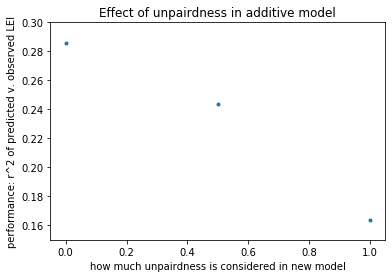

In [58]:
x_vals = [0,0.5,1]
y_vals = [0.286,0.244,0.164]
plt.plot(x_vals,y_vals,'.')
plt.ylim(0.15,.3)
plt.title("Effect of unpairdness in additive model")
plt.xlabel("how much unpairdness is considered in new model")
plt.ylabel("performance: r^2 of predicted v. observed LEI")

Text(0, 0.5, 'performance: r^2 of observed v. predicted')

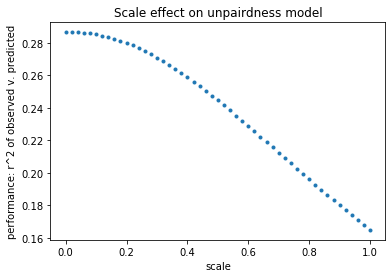

In [36]:
plt.plot([item[0] for item in scale_performance],[item[1] for item in scale_performance],'.')
slope, intercept, r_value, p_value, std_err = stats.linregress([item[0] for item in scale_performance],\
                                                               [item[1] for item in scale_performance])
plt.title("Scale effect on unpairdness model")
plt.xlabel("scale")
plt.ylabel("performance: r^2 of observed v. predicted")